In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import numpy as np
import statsmodels.api as sm

In [2]:
%config Inlinebackend.figure_format= 'retina'

# Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

Objective: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

Dataset: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

In [3]:
prize_prediction_df = pd.read_csv("dataset/amz_uk_price_prediction_dataset.csv")

prize_prediction_df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


## Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

### 1. Crosstab Analysis:

In [4]:
crosstab_df = pd.crosstab(prize_prediction_df["category"], prize_prediction_df["isBestSeller"])

crosstab_prop_df = crosstab_df.copy()
crosstab_prop_df["bs_proportion"] = crosstab_df[True] / (crosstab_df[True] + crosstab_df[False])
crosstab_prop_df = crosstab_prop_df.sort_values("bs_proportion", ascending=False)
crosstab_prop_df

isBestSeller,False,True,bs_proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


The categories where the best selleres are more prevalent are Grocery, Smart Home Security & Lighting and Health & Personal Care, but, in the 3 cases, the percentage of best sellers is less that 6% (so it is low)

### 2. Statistical Tests:

In [5]:
_, chi2_pvalue, _, _ = chi2_contingency(crosstab_df)
cramerv = association(crosstab_df, method='cramer')

print("Chi-square tests:  ", chi2_pvalue)
print("Cramér's V:  ", cramerv)

Chi-square tests:   0.0
Cramér's V:   0.1222829439760564


While Chi-square shows a relation (result < 0.05) between these features, Cramér's V shows they have a Weak association (value in between 0.1 and 0.2)

### 3. Visualizations:

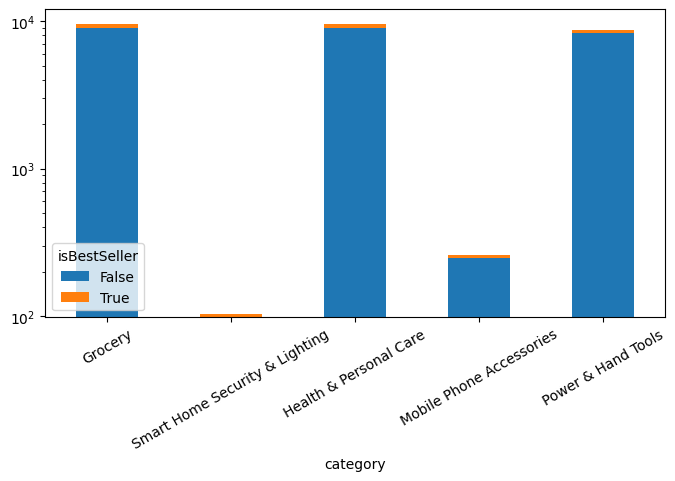

In [6]:
#Showing only top 5 because is not possible to see all the categories
ax = crosstab_prop_df[[0,1]].head(5).plot(kind='bar', stacked=True, figsize=(8,4))
plt.xticks(rotation=30) 
ax.set_yscale('log') # just for improve visibility
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

### 0. Preliminary Step: Remove outliers in product prices.

In [7]:
# (count(products.import) < q25) - 1.5  (IQR)
q1 = prize_prediction_df["price"].quantile(0.25)
q3 = prize_prediction_df["price"].quantile(0.75)
iqr = q3 - q1
foutlaiers = q1 - (iqr * 1.5)
loutlaiers = q3 + (iqr * 1.5)

nooutlaiers_df = prize_prediction_df[(prize_prediction_df["price"] > foutlaiers) & (prize_prediction_df["price"] < loutlaiers)]
nooutlaiers_df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


### 1. Violin Plots:

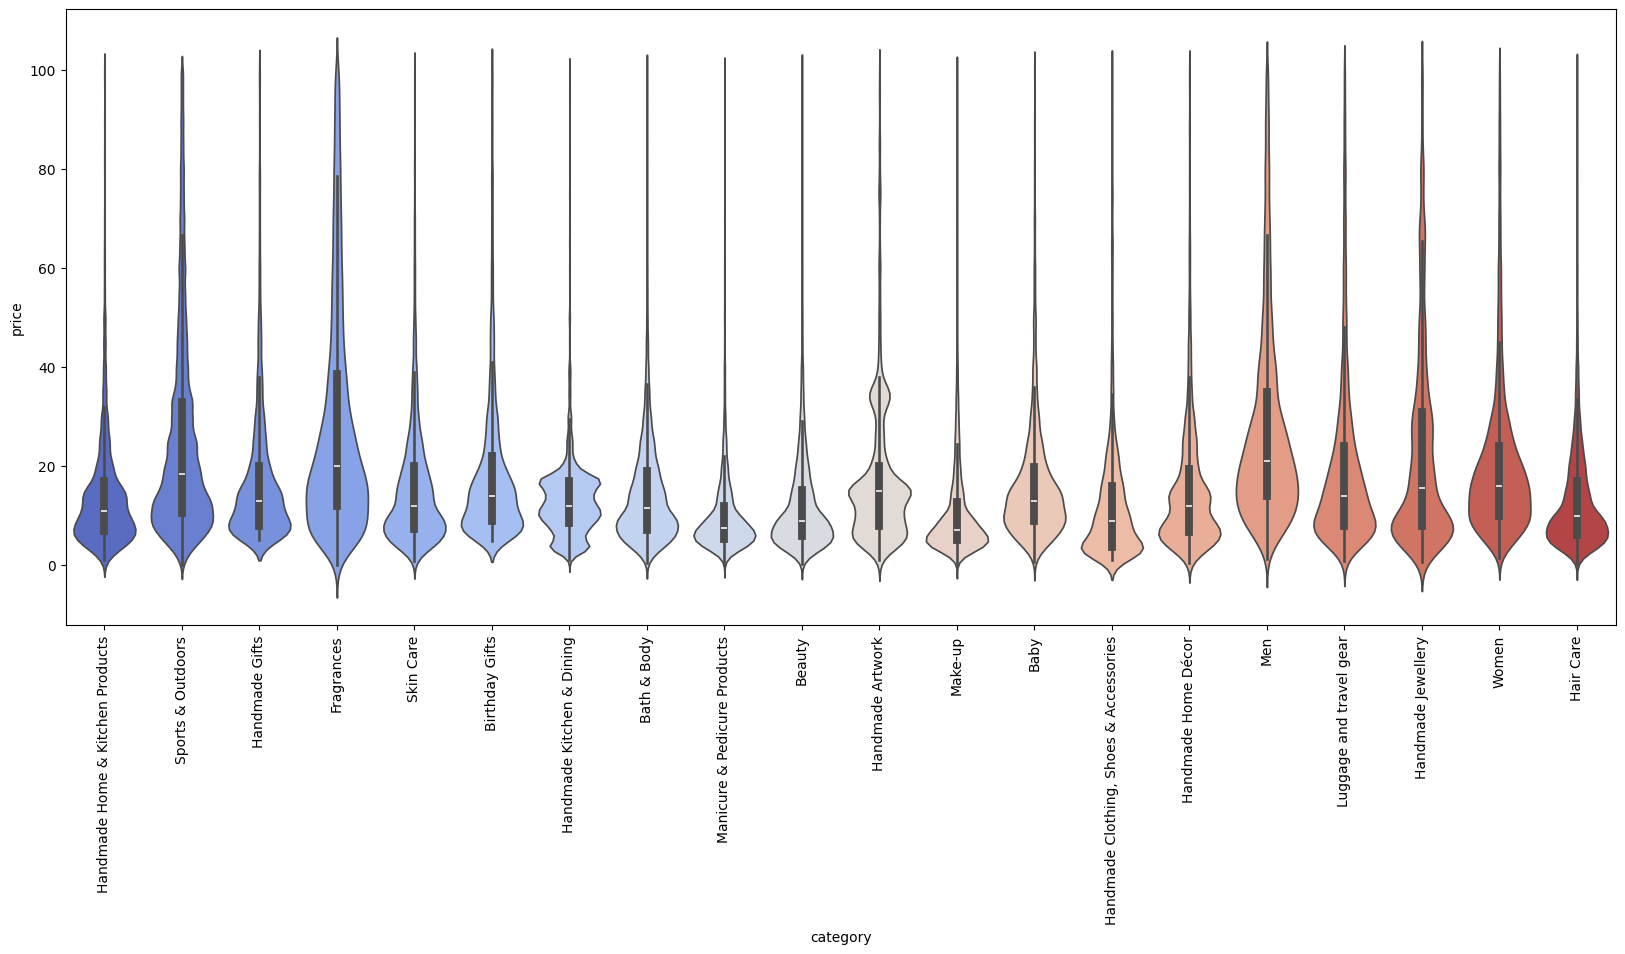

In [14]:
# Order Categories based on count
top_df = nooutlaiers_df[["category", "price"]].groupby("category").count().sort_values("price", ascending = False)

# Filter Top 20
p2ex1_df = nooutlaiers_df[nooutlaiers_df["category"].isin(top_df[:20].index)]

# Draw plot
plt.figure(figsize=(20, 8))
sns.violinplot(data=p2ex1_df, x="category", y="price", hue="category", palette="coolwarm")
plt.xticks(rotation=90)
plt.show();

### 2. Bar Charts:

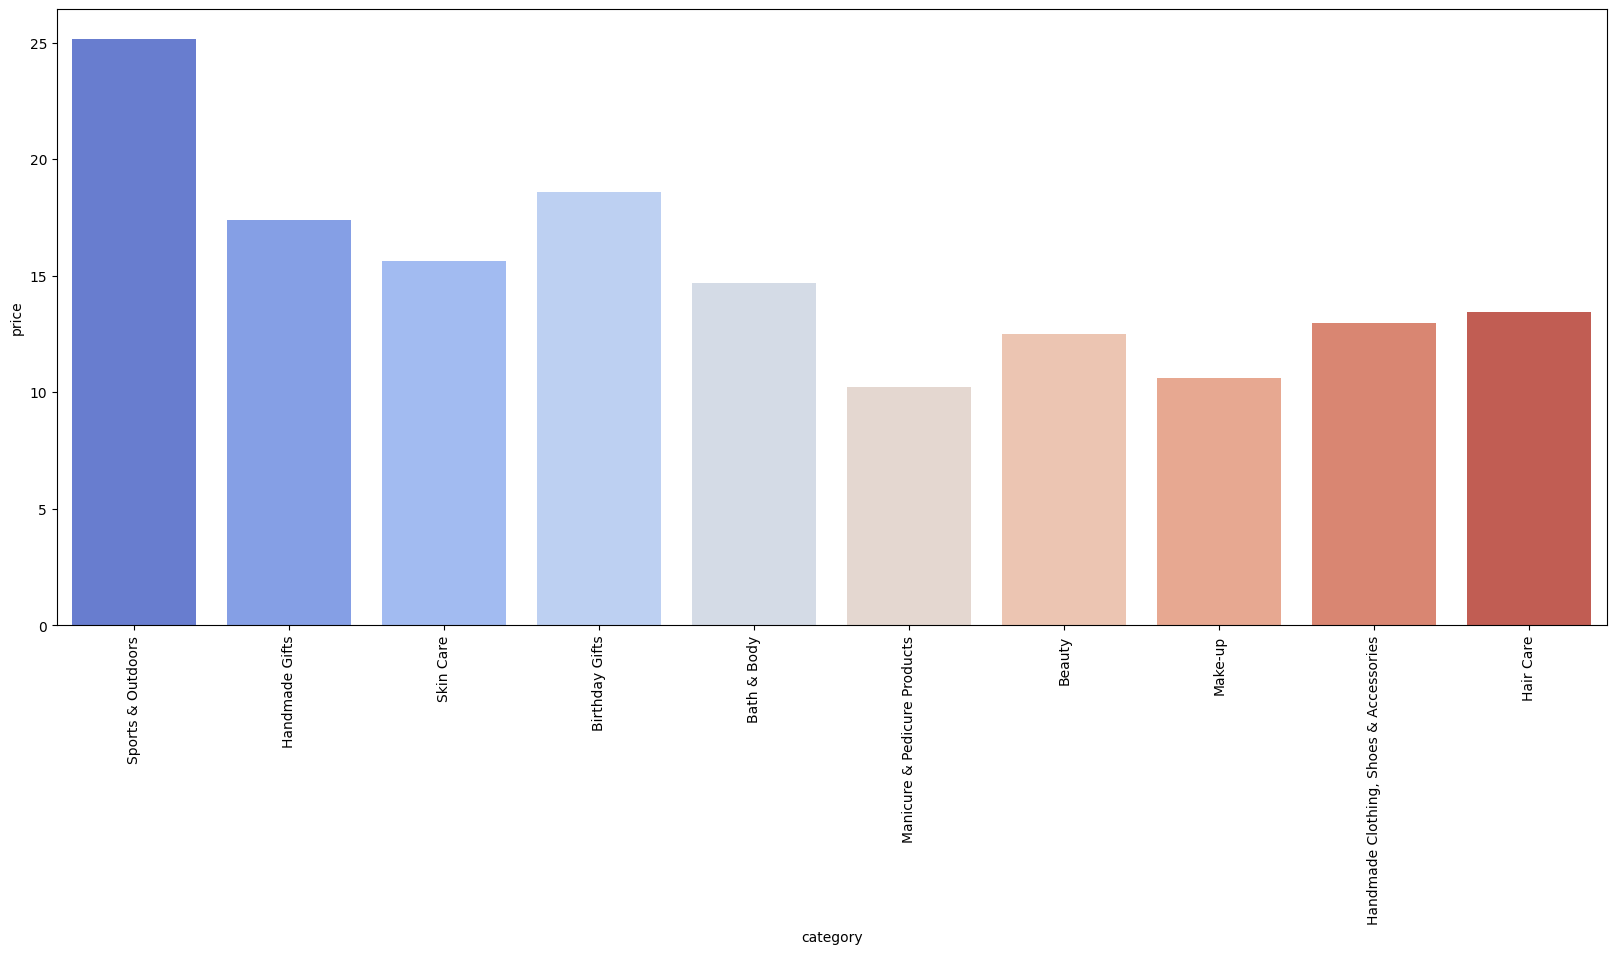

In [21]:
# Filter Top 10
p2ex2_df = nooutlaiers_df[nooutlaiers_df["category"].isin(top_df[:10].index)]

# Draw plot
plt.figure(figsize=(20, 8))
sns.barplot(data=p2ex2_df, x="category", y="price", hue="category", palette="coolwarm", errorbar=None, estimator="mean")
plt.xticks(rotation=90)
plt.show();

The top categories based on count are: \
Sports & Outdoors, Handmade Gifts, Skin Carem Birthday Gifts, Bath & Body, Manicure & Pedicure Products, Beauty, Make-up, Handmade Clothings, Shoes & Accessores and  Hair Care

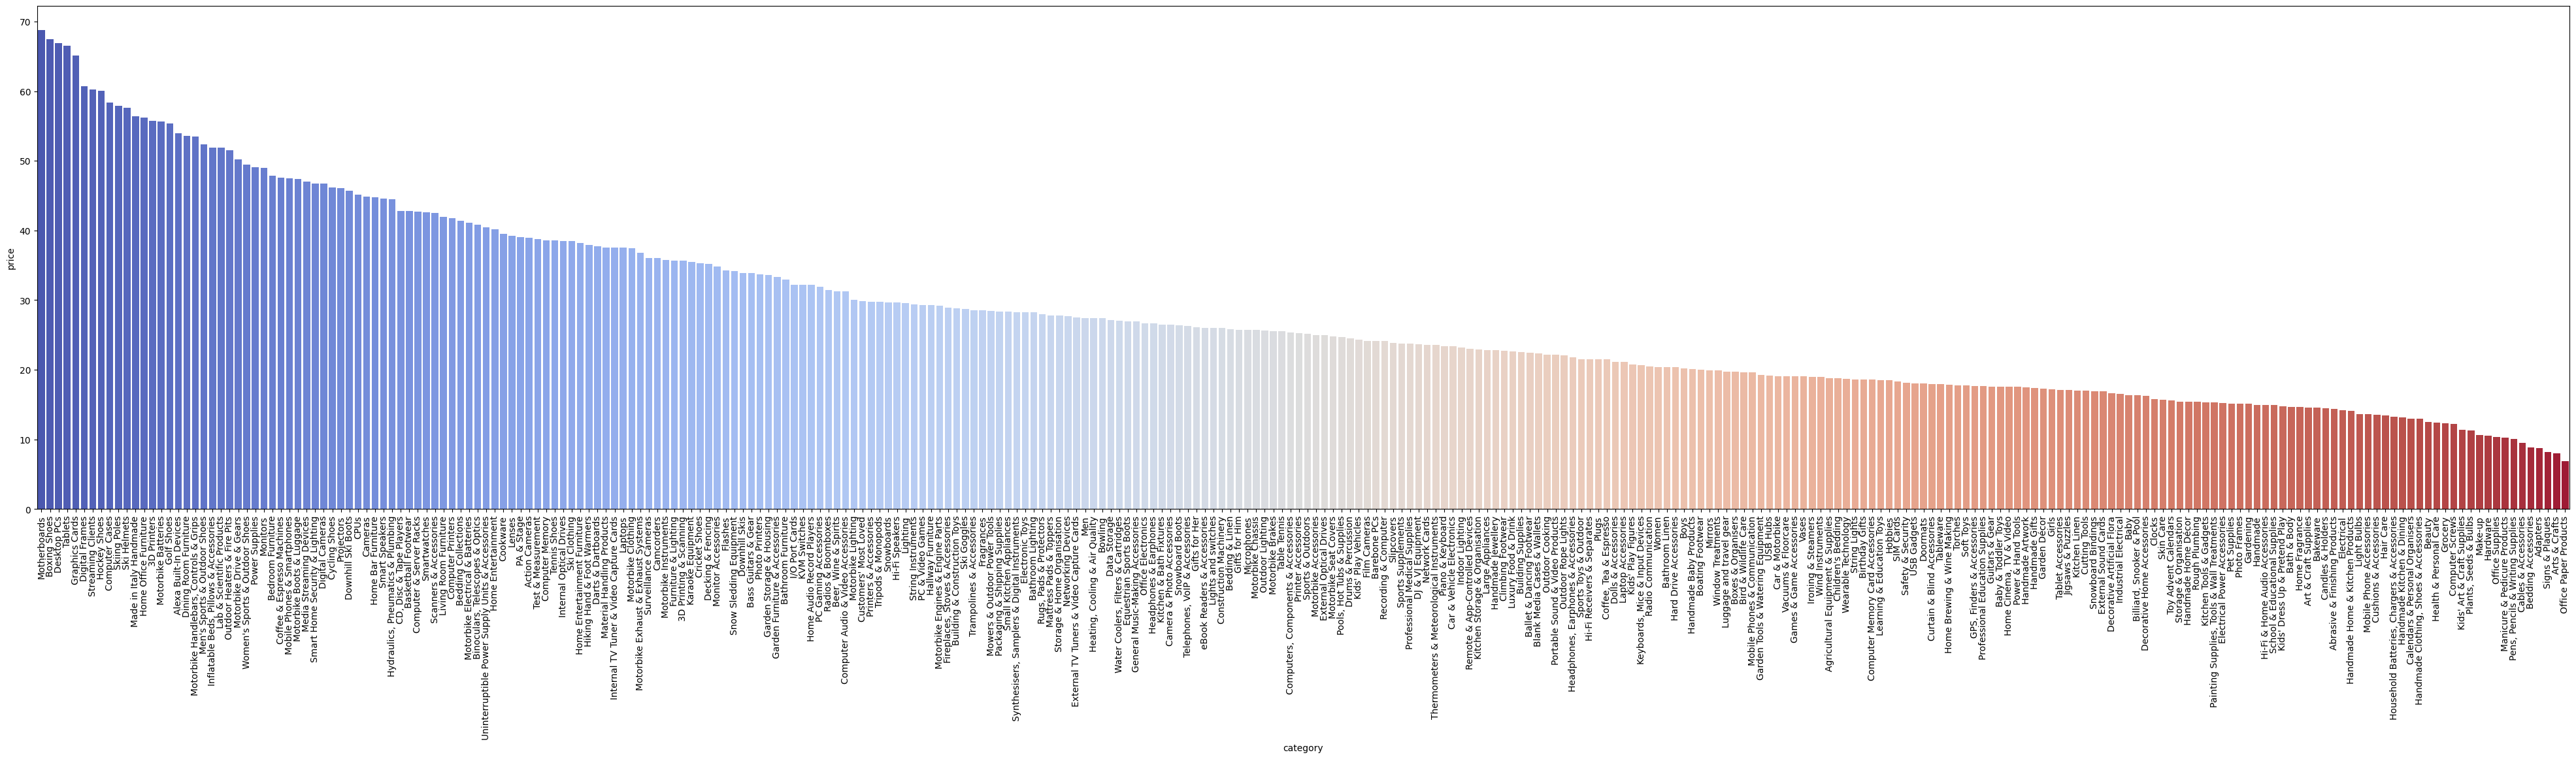

In [30]:
p2ex2_2_df = nooutlaiers_df[["category", "price"]].groupby("category").mean().sort_values("price", ascending=False)

# Draw plot
plt.figure(figsize=(50, 10))
sns.barplot(data=p2ex2_2_df, x="category", y="price", hue="category", palette="coolwarm", errorbar=None)
plt.xticks(rotation=90)
plt.show();

Motherboard is the category with high AVG Price

## Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

### 1. Correlation Coefficients:

In [32]:
corr_pearson = round(float(nooutlaiers_df["stars"].corr(nooutlaiers_df["price"], method="pearson")), 2)
corr_spearman = round(float(nooutlaiers_df["stars"].corr(nooutlaiers_df["price"], method="spearman")), 2)

print("Pearson correlation?", corr_pearson)
print("Spearman correlation?", corr_spearman)

Pearson correlation? -0.08
Spearman correlation? -0.07


Pearson and Spearman don't show a significant correlation between stars and price.

### 2. Visualizations:

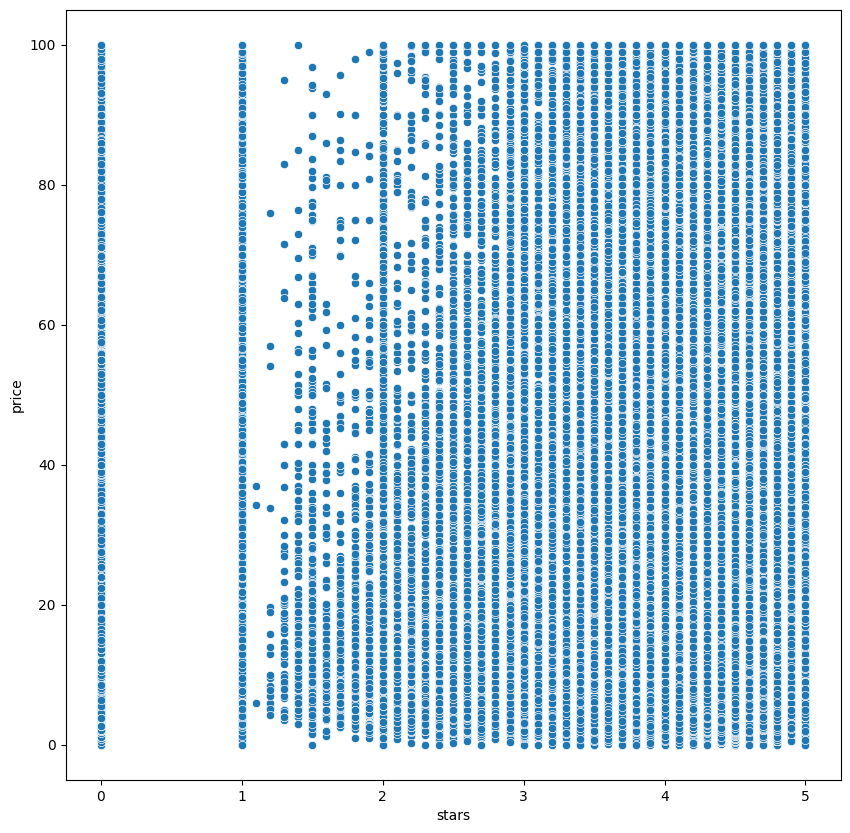

In [37]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=nooutlaiers_df, x='stars', y='price')
plt.show();

I see a clear separation in between 0 and 1 (there are no values between them) this is because 0 means "not rated" and 1 is the minimum rate.
I can see that for cheaper prices (bellow 40) there is less reviews in between 1 and 1.5.
From 2.5 stars is diffucult to take any conclusion due the density of points.

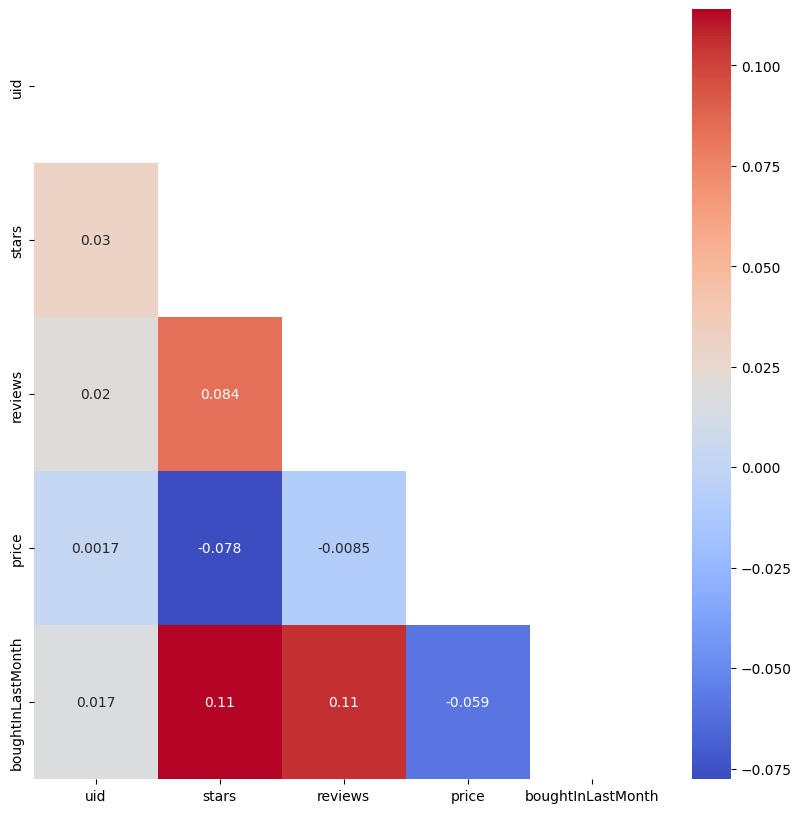

In [69]:
correlation_matrix = nooutlaiers_df.select_dtypes(include="number").corr()

# This is optional to improve visualization
# It removes the duplicated values (half table)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creating the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show()

Highest relation between feratures is between the stars and reviews with boughtLastMonth but the value still seems to be low

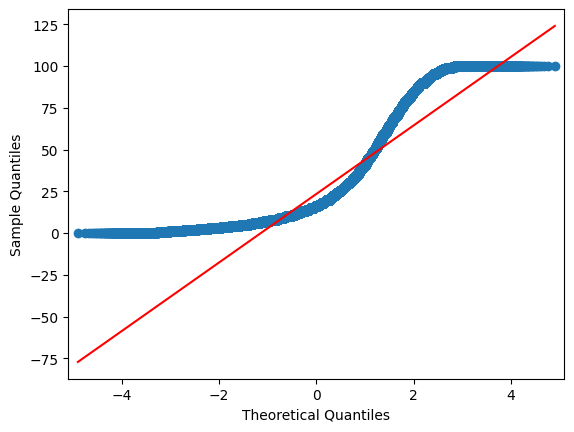

In [48]:
sm.qqplot(nooutlaiers_df['price'], line='s');
plt.show()

Product prices do not follow a normal distribution

## Bonus
Do the same analysis without taking out the outliers. What are your insights?

### 1. Violin plots

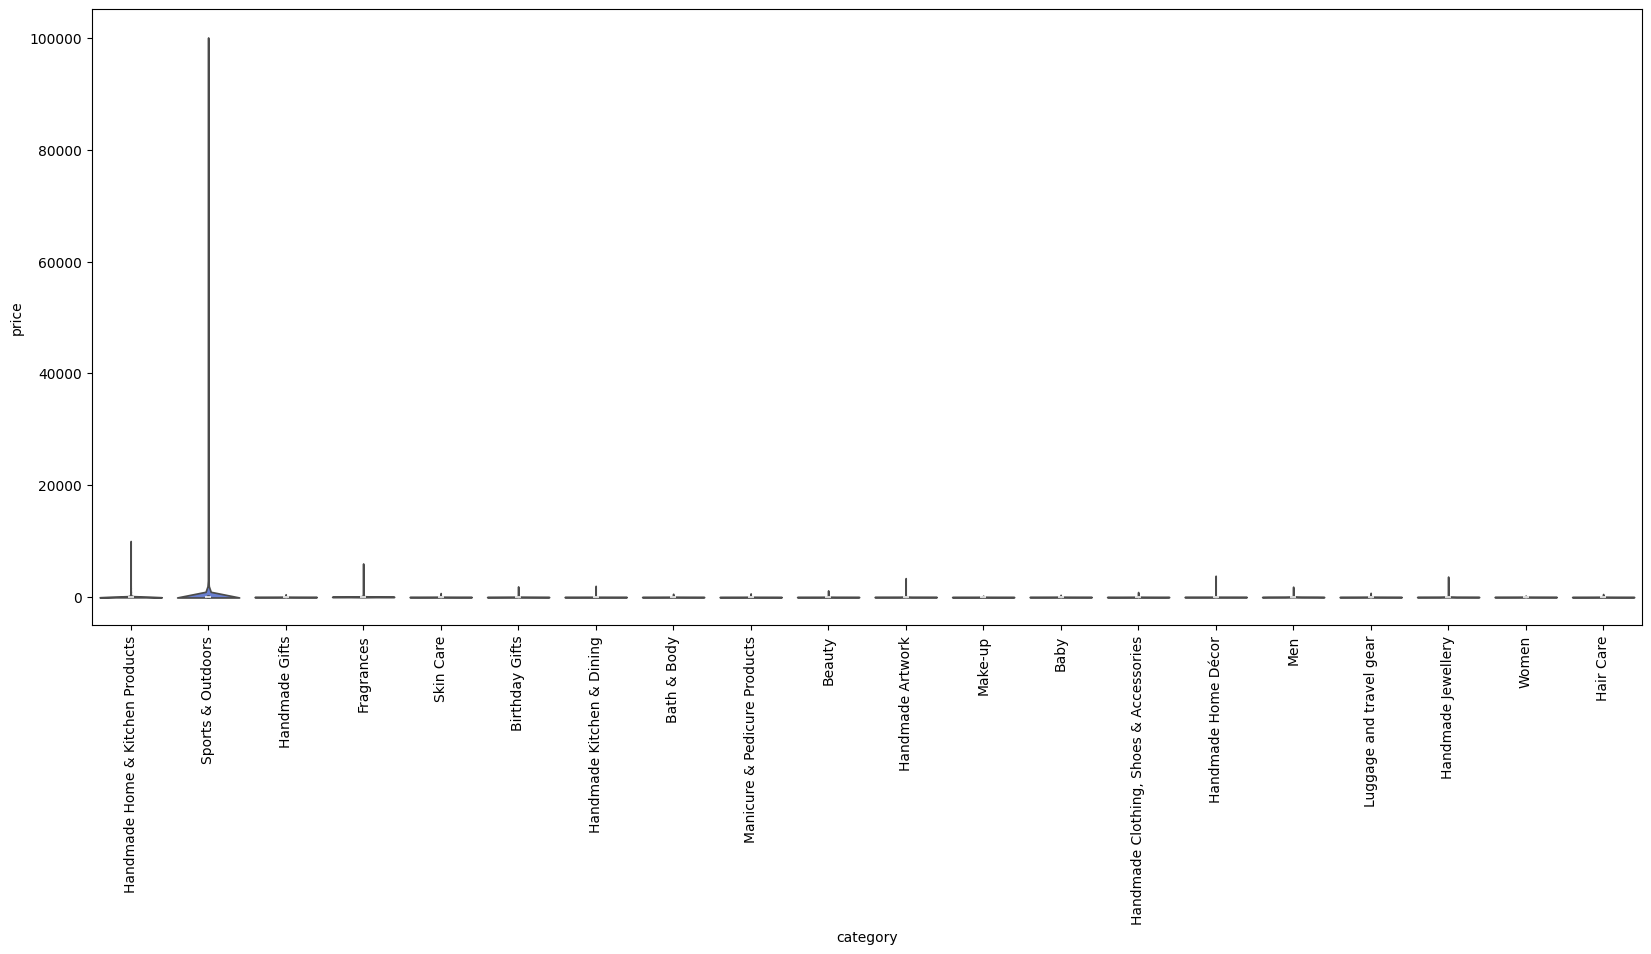

In [52]:
# Order Categories based on count
top_df = prize_prediction_df[["category", "price"]].groupby("category").count().sort_values("price", ascending = False)

# Filter Top 20
p2ex1_df = prize_prediction_df[prize_prediction_df["category"].isin(top_df[:20].index)]

# Draw plot
plt.figure(figsize=(20, 8))
ax = sns.violinplot(data=p2ex1_df, x="category", y="price", hue="category", palette="coolwarm")
plt.xticks(rotation=90)

plt.show();

I  am not able to take any conclusion in this visualization

### 2. Bar Charts

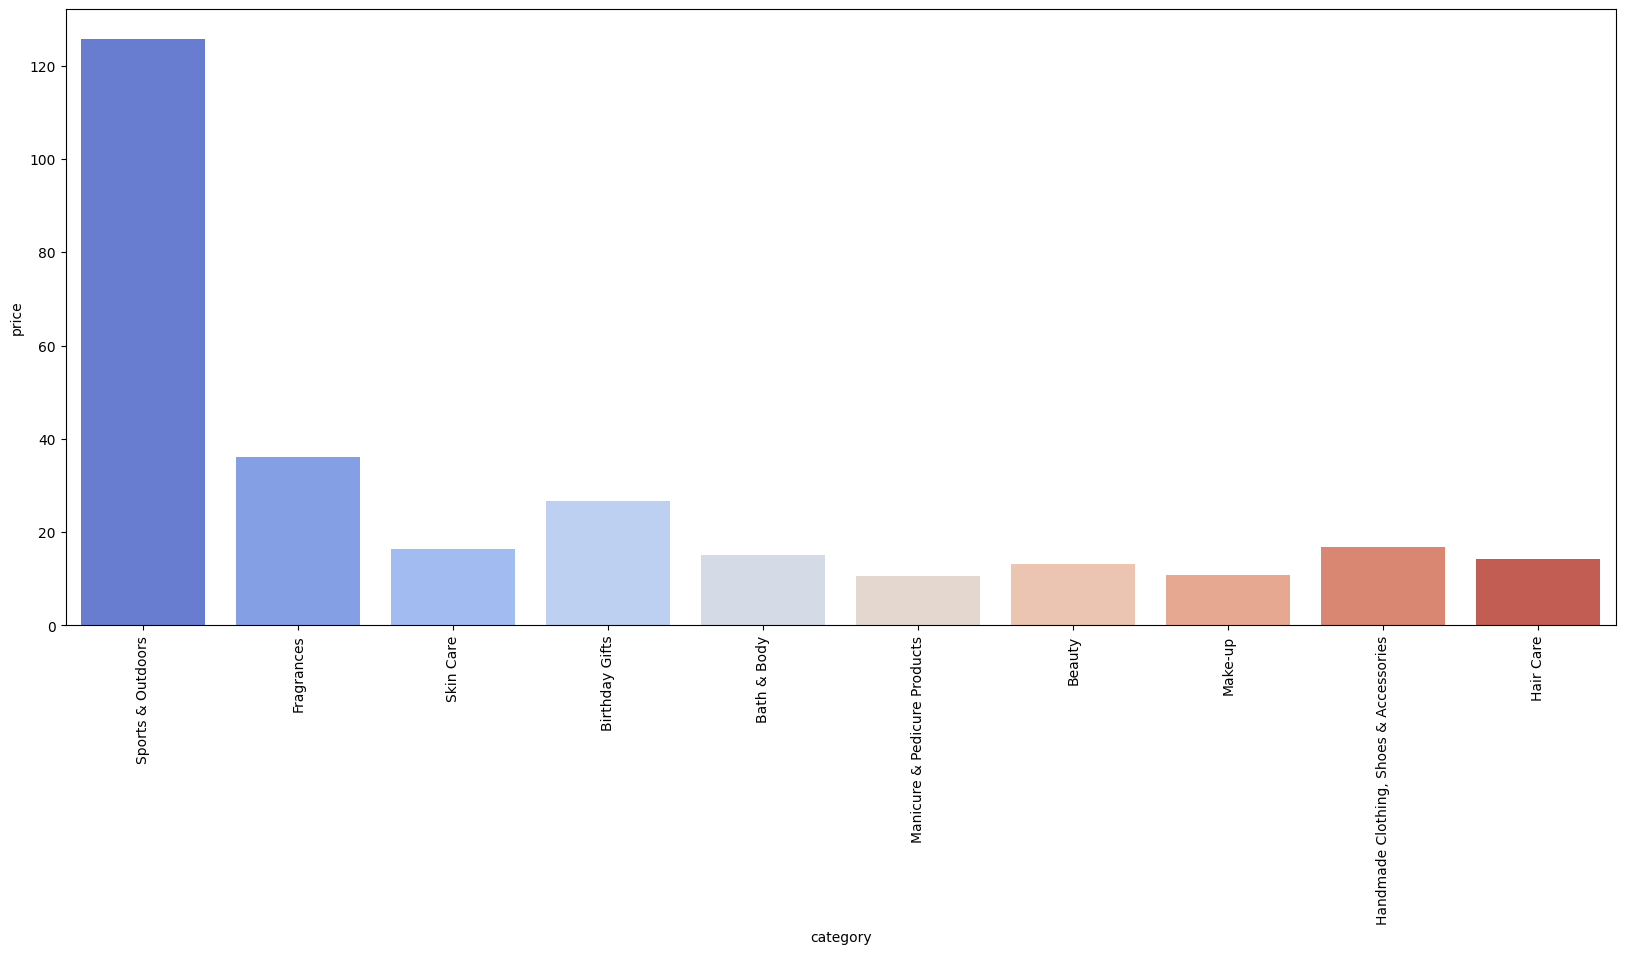

In [53]:
# Filter Top 10
p2ex2_df = prize_prediction_df[prize_prediction_df["category"].isin(top_df[:10].index)]

# Draw plot
plt.figure(figsize=(20, 8))
sns.barplot(data=p2ex2_df, x="category", y="price", hue="category", palette="coolwarm", errorbar=None, estimator="mean")
plt.xticks(rotation=90)
plt.show();

While Sports& Ourdors keep being the top category based on count other categories has changed. \
We can see new categories as Frances becoming the second and at the same time Handmade Gifts (the second category in the last analysis) has desapeard from the top.

This might be because Fragancies use to have high prices so a big amount of them were outlaiers in the last anlysis.

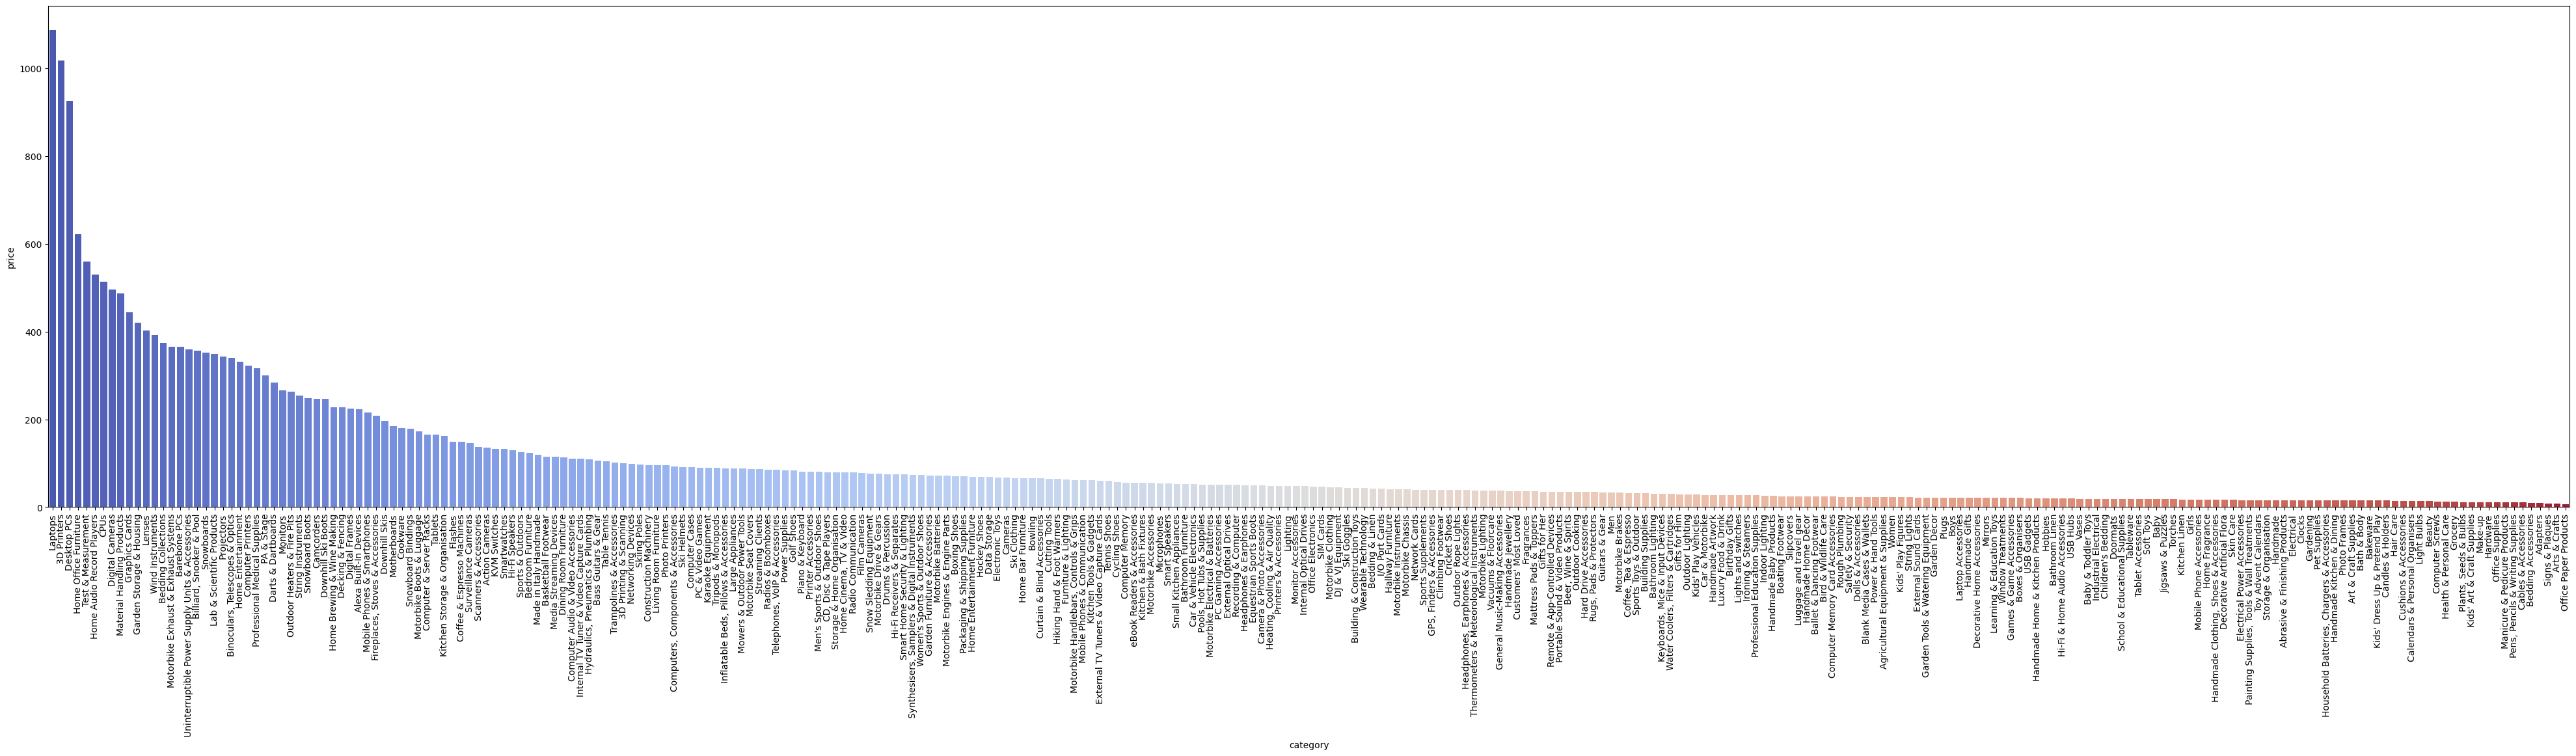

In [55]:
p2ex2_2_df = prize_prediction_df[["category", "price"]].groupby("category").mean().sort_values("price", ascending=False)

# Draw plot
plt.figure(figsize=(50, 10))
sns.barplot(data=p2ex2_2_df, x="category", y="price", hue="category", palette="coolwarm", errorbar=None)
plt.xticks(rotation=90)
plt.show();

Laptops is now the category with higher prices and the MAX mean price in the Y axis has increased from 70 to 1000

### 3. Correlation Coefficients:

In [59]:
corr_pearson = round(float(prize_prediction_df["stars"].corr(prize_prediction_df["price"], method="pearson")), 2)
corr_spearman = round(float(prize_prediction_df["stars"].corr(prize_prediction_df["price"], method="spearman")), 2)

print("Pearson correlation?", corr_pearson)
print("Spearman correlation?", corr_spearman)

Pearson correlation? -0.12
Spearman correlation? -0.13


We see a higher (negative) correlation between stars and prices by not extracting the outlaies

### 4. Visualizations

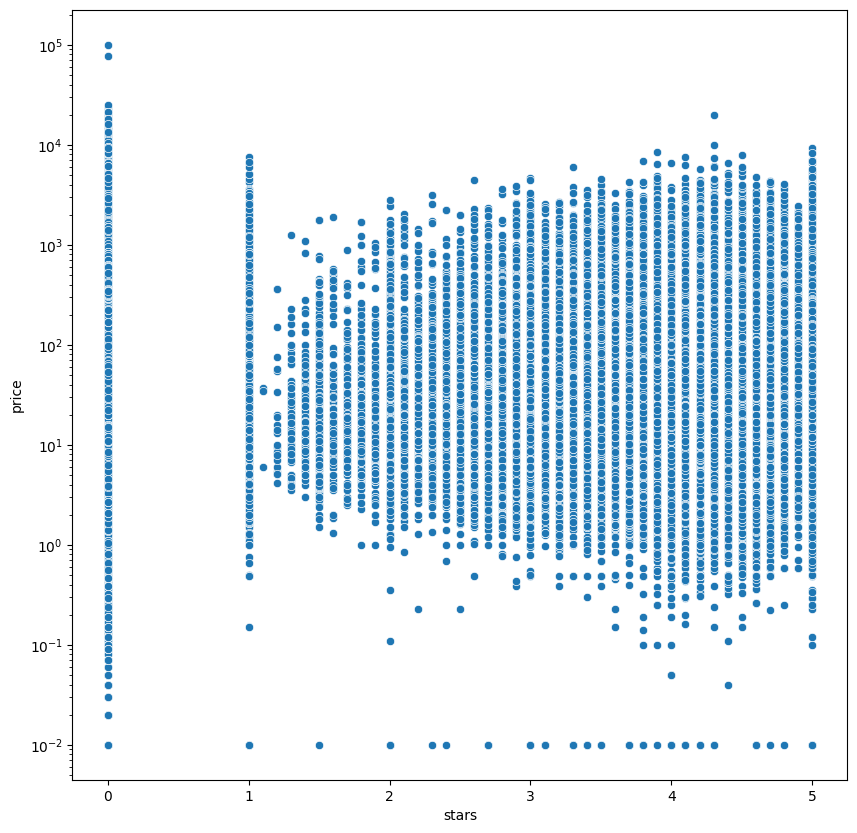

In [67]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=prize_prediction_df, x='stars', y='price')
ax.set(yscale='log')
plt.show();

I decided to use a logaritmic scale for prices in otder to be able to review the chart.
I can't take many conclusions but it call to my attention that product with prices between 0-5 and over 1000 seems to not have many rates in between 1 and 3.  That could be because their rates are higher, because people don't rate these products or because there are not much products on that range (more probable in the range over 10000)

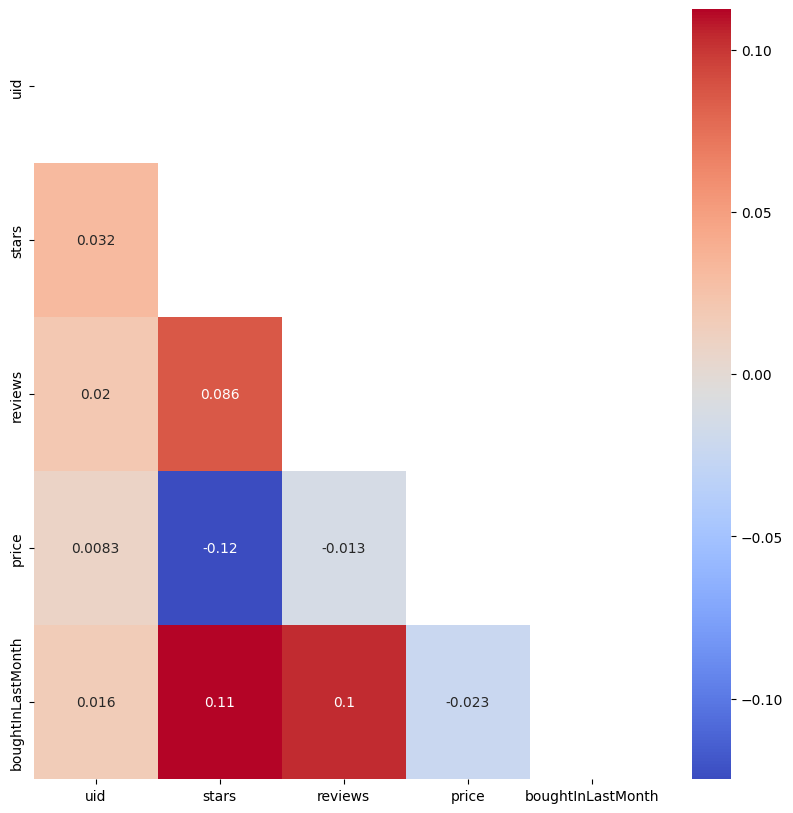

In [70]:
correlation_matrix = prize_prediction_df.select_dtypes(include="number").corr()

# This is optional to improve visualization
# It removes the duplicated values (half table)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creating the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show()

We can see higher correlations between some values like stars-price or price-boughtLastMonth but I still feel they are low correlations

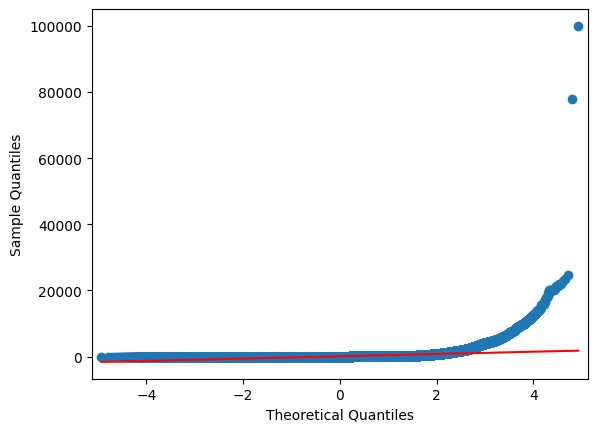

In [73]:
sm.qqplot(prize_prediction_df['price'], line='s')
plt.show()

Prices follow more a normal distribution except for the top values where the prices seems to grow in a more exponential way.